In [198]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [200]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

# # convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])
image_resize = 128
transform = transforms.Compose([
    transforms.Resize((image_resize, image_resize)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


In [201]:
# loading the train data
batch_size = 32
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )


Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [202]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        # He Weight Initialization
        self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)
        self.prev_wchange = torch.zeros((n_inputs, n_neurons))
        self.prev_bchange = torch.zeros((1, n_neurons))
        self.prev_wchange = self.prev_wchange.to(device)
        self.prev_bchange = self.prev_bchange.to(device)

    
    def forward(self, inputs):
        self.inputs = inputs
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Activation Layers


In [203]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        return torch.maximum(torch.zeros_like(inputs), inputs)

    def backward(self, output_error):
        self.inputs_error = output_error.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error


In [204]:
class Sigmoid:
    def forward(self,inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        self.outputs.to(device)
        return self.outputs

    def backward(self,output_error):
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs
        self.outputs_grad = self.outputs_grad.to(device)
        return self.outputs_grad

In [205]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs



### Loss function

In [206]:
class Categorical_Cross_Entropy_loss:
    
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [207]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.001):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        #self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        # if epoch < self.warmup_steps:
        #     return self.get_warmup_lr(epoch)
        # if epoch <= self.max_update:
        #     self.base_lr = self.final_lr + (
        #         self.base_lr_orig - self.final_lr) * (1 + math.cos(
        #         math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        #return self.base_lr
        return self.base_lr_orig

In [208]:
class SGD:
    def __init__(self, learning_rate=0.01, momentum = 0.9):
        self.learning_rate=learning_rate
        self.scheduler = CosineScheduler(max_update=20, base_lr=learning_rate, final_lr=0.0001) #FactorScheduler(factor=0.9, stop_factor_lr=0.0001, base_lr=learning_rate)
        self.momentum = momentum
    
    def __call__(self, layer, num_epoch):
        device = layer.weights.device
        layer.weights = layer.weights.to(device)
        layer.biases = layer.biases.to(device)
        cur_wchange = self.scheduler(num_epoch) * layer.weights_grad.to(device) + self.momentum * layer.prev_wchange.to(device)
        layer.weights -= cur_wchange
        cur_bchange = self.scheduler(num_epoch) * layer.biases_grad.to(device) + self.momentum * layer.prev_bchange.to(device)
        layer.biases -= cur_bchange
        layer.prev_wchange = cur_wchange
        layer.prev_bchange = cur_bchange
        



### Architecture

In [ ]:
# feature_extractor = torchvision.models.resnet34(pretrained=True)
# feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-1])
# for param in feature_extractor.parameters():
#     param.requires_grad = False

feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [210]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate=0.001,momentum=0)

In [90]:
history = {}
train_acc = {'16':[],'32':[],'64':[],'128':[]}
train_loss = {'16':[],'32':[],'64':[],'128':[]}
test_loss = {'16':[],'32':[],'64':[],'128':[]}
test_acc = {'16':[],'32':[],'64':[],'128':[]}
test_accuracy = {'16':[],'32':[],'64':[],'128':[]}

In [211]:
train_acc['32'] = []
train_loss['32'] = []
test_loss['32'] = []
test_acc['32'] = []

### Train

In [186]:


epochs = 20
y_predtr= torch.zeros(0,dtype=torch.long, device=device)
y_true_train = torch.zeros(0,dtype=torch.long, device=device)
y_predts= torch.zeros(0,dtype=torch.long, device=device)
y_true_test = torch.zeros(0,dtype=torch.long, device=device)
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_test_loss = 0
    epoch_test_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy.item()
        if epoch == epochs-1:
            y_predtr=torch.cat([y_predtr,y_predict_train.view(-1)])
            y_true_train=torch.cat([y_true_train,y_train.view(-1)])
        # Backward pass
        x = Loss.backward(y_train)
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    with torch.no_grad():
        for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
                # Forward pass
                x_test, y_test = x_test.to(device), y_test.to(device)
                x = feature_extractor(x_test)
                x = Layer1.forward(x)
                x = Act1.forward(x)
                x = Layer2.forward(x)
                x = Act2.forward(x)
                loss = Loss.forward(x, y_test)

                # Report batch metrics
                y_predict_test = torch.argmax(x, dim=1)
                accuracy = torch.mean((y_test == y_predict_test).float())
                epoch_test_loss += loss.item()
                epoch_test_accuracy += accuracy.item()
                if epoch == epochs-1:
                    y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
                    y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
    # Report epoch metrics
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    epoch_test_loss /= len(test_dataloader)
    epoch_test_accuracy /= len(test_dataloader)
    train_loss[f'{batch_size}'].append(epoch_train_loss)
    train_acc[f'{batch_size}'].append(epoch_train_accuracy)
    test_loss[f'{batch_size}'].append(epoch_test_loss)
    test_acc[f'{batch_size}'].append(epoch_test_accuracy)
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {epoch_train_loss:.7f}')
    print(f'Train Accuracy: {epoch_train_accuracy:.7f}')
    print(f'Test Loss: {epoch_test_loss:.7f}')
    print(f'Test Accuracy: {epoch_test_accuracy:.7f}')
    print('--------------------------')


Testing: 100%|██████████| 313/313 [00:11<00:00, 27.15it/s]


Epoch: 1
Train Loss: 0.9187200
Train Accuracy: 0.6881598
Test Loss: 0.8997842
Test Accuracy: 0.6969848
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.46it/s]


Epoch: 2
Train Loss: 0.8549485
Train Accuracy: 0.7082933
Test Loss: 0.8492095
Test Accuracy: 0.7133586
--------------------------


Testing: 100%|██████████| 313/313 [00:14<00:00, 21.82it/s]


Epoch: 3
Train Loss: 0.8118142
Train Accuracy: 0.7239883
Test Loss: 0.8109313
Test Accuracy: 0.7271366
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 26.50it/s]


Epoch: 4
Train Loss: 0.7813896
Train Accuracy: 0.7345849
Test Loss: 0.7857386
Test Accuracy: 0.7359225
--------------------------


Testing: 100%|██████████| 313/313 [00:13<00:00, 23.36it/s]


Epoch: 5
Train Loss: 0.7548808
Train Accuracy: 0.7440619
Test Loss: 0.7669581
Test Accuracy: 0.7387181
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 29.67it/s]


Epoch: 6
Train Loss: 0.7382866
Train Accuracy: 0.7501599
Test Loss: 0.7481336
Test Accuracy: 0.7483027
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.99it/s]


Epoch: 7
Train Loss: 0.7187507
Train Accuracy: 0.7535189
Test Loss: 0.7363942
Test Accuracy: 0.7516973
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 26.82it/s]


Epoch: 8
Train Loss: 0.7089177
Train Accuracy: 0.7580174
Test Loss: 0.7269250
Test Accuracy: 0.7537939
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 27.96it/s]


Epoch: 9
Train Loss: 0.6973650
Train Accuracy: 0.7617562
Test Loss: 0.7185356
Test Accuracy: 0.7552915
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 27.24it/s]


Epoch: 10
Train Loss: 0.6879234
Train Accuracy: 0.7650152
Test Loss: 0.7119684
Test Accuracy: 0.7564896
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.95it/s]


Epoch: 11
Train Loss: 0.6826875
Train Accuracy: 0.7658949
Test Loss: 0.7046660
Test Accuracy: 0.7592851
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 30.75it/s]


Epoch: 12
Train Loss: 0.6711085
Train Accuracy: 0.7683541
Test Loss: 0.6964237
Test Accuracy: 0.7611821
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.47it/s]


Epoch: 13
Train Loss: 0.6672760
Train Accuracy: 0.7719330
Test Loss: 0.6941826
Test Accuracy: 0.7639776
--------------------------


Testing: 100%|██████████| 313/313 [00:12<00:00, 24.65it/s]


Epoch: 14
Train Loss: 0.6582394
Train Accuracy: 0.7734725
Test Loss: 0.6906159
Test Accuracy: 0.7640775
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.51it/s]


Epoch: 15
Train Loss: 0.6564367
Train Accuracy: 0.7751120
Test Loss: 0.6861017
Test Accuracy: 0.7654752
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.53it/s]


Epoch: 16
Train Loss: 0.6531086
Train Accuracy: 0.7760717
Test Loss: 0.6827451
Test Accuracy: 0.7686701
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 28.66it/s]


Epoch: 17
Train Loss: 0.6456176
Train Accuracy: 0.7785709
Test Loss: 0.6771123
Test Accuracy: 0.7702676
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 27.95it/s]


Epoch: 18
Train Loss: 0.6405144
Train Accuracy: 0.7804902
Test Loss: 0.6739578
Test Accuracy: 0.7700679
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 27.47it/s]


Epoch: 19
Train Loss: 0.6347838
Train Accuracy: 0.7831494
Test Loss: 0.6726152
Test Accuracy: 0.7712660
--------------------------


Testing: 100%|██████████| 313/313 [00:11<00:00, 28.09it/s]

Epoch: 20
Train Loss: 0.6328822
Train Accuracy: 0.7835693
Test Loss: 0.6696689
Test Accuracy: 0.7732628
--------------------------


### Test

In [ ]:

# with torch.no_grad():
#         for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
#                 # Forward pass
#                 x_test, y_test = x_test.to(device), y_test.to(device)
#                 x = feature_extractor(x_test)
#                 x = Layer1.forward(x)
#                 x = Act1.forward(x)
#                 x = Layer2.forward(x)
#                 x = Act2.forward(x)
#                 loss = Loss.forward(x, y_test)

#                 # Report batch metrics
#                 y_predict_test = torch.argmax(x, dim=1)
#                 accuracy = torch.mean((y_test == y_predict_test).float())
#                 test_loss += loss.item()
#                 test_accuracy += accuracy.item()
#                 y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
#                 y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
# test_loss /= len(test_dataloader)
# test_accuracy /= len(test_dataloader)
# print(f'Test Loss: {test_loss:.7f}')
# print(f'Test Accuracy: {test_accuracy:.7f}')

   

### Evaluation

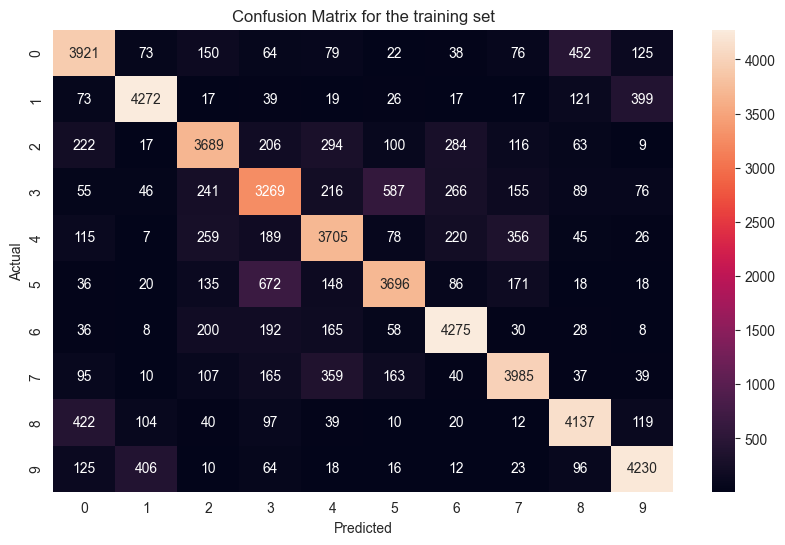

In [187]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predtr.data.cpu().numpy()
y_train_numpy = y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()



In [188]:
print(f1_score(y_train_numpy, y_predtr_numpy, average='weighted'))

0.7832854052979705


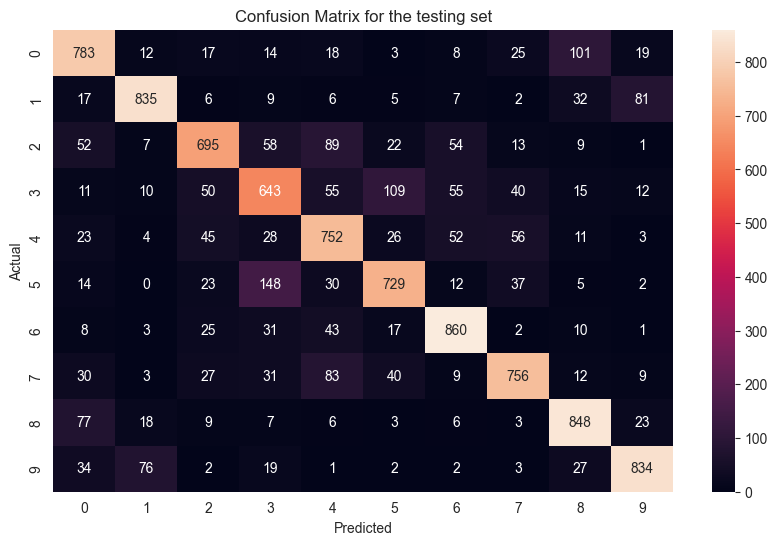

In [189]:
#Confusion Matrix for the test set
y_predts_numpy = y_predts.data.cpu().numpy()
y_test_numpy = y_true_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()

In [190]:
print(f1_score(y_test_numpy, y_predts_numpy, average='weighted'))

0.7732276529651568


In [213]:
# Set up the plot
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_loss.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend(title = 'batch size')

# Show the plot
plt.show()
print(len(train_acc))

0


In [216]:
# train acc 
# Set up the plot
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_acc.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')
plt.legend(title = 'batch size')

# Show the plot
plt.show()
print(len(train_acc))

20


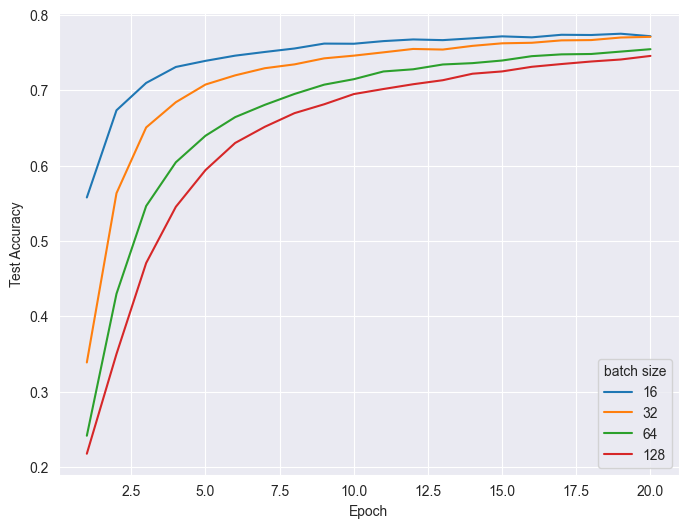

4


In [169]:
# test acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_acc.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(title = 'batch size')

# Show the plot
plt.show()
print(len(train_acc))

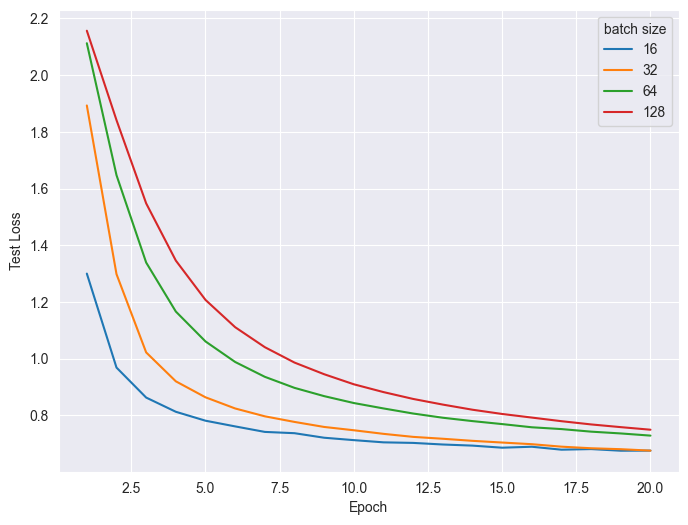

4


In [170]:
# test loss 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_loss.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(title = 'batch size')

# Show the plot
plt.show()
print(len(train_acc))